# Improve recognition of handwritten digits using Monte Carlo dropout

In this notebook, [Monte Carlo dropout](https://arxiv.org/abs/1506.02142) is applied for improving the recognition of handwritten digits from the MNIST dataset using neural networks. As the focus is on experimenting with Monte Carlo dropout, a very simple model is used.

Some of the code below is taken from a [Keras tutorial](https://github.com/tensorflow/datasets/blob/master/docs/keras_example.ipynb).

In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as sk_metrics

np.random.seed(7)
tf.random.set_seed(7)

## Load MNIST dataset

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

## Build training and evaluation pipelines

In [3]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

train_batch_size = 128
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(train_batch_size)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

test_batch_size = 128
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(test_batch_size)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## Create and train the model

In [4]:
def build_model(use_mc_dropout=False):
    inputs = tf.keras.Input(shape=(28, 28, 1))
    flattened = tf.keras.layers.Flatten()(inputs)
    dense = tf.keras.layers.Dense(128, activation='relu')(flattened)
    dropout = tf.keras.layers.Dropout(0.25)(dense, training=use_mc_dropout)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(dropout)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist_model')

def build_train_model(*, ds_train, ds_test, use_mc_dropout=False, verbose=False):
    model = build_model(use_mc_dropout=use_mc_dropout)

    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(0.001), 
                  metrics=['accuracy'])
    if verbose:
        model.summary()

    model.fit(ds_train, epochs=25, validation_data=ds_test)
    
    return model

model_no_mc_dropout = build_train_model(ds_train=ds_train, ds_test=ds_test, use_mc_dropout=False)
model_mc_dropout = build_train_model(ds_train=ds_train, ds_test=ds_test, use_mc_dropout=True)

Epoch 1/25
469/469 [==============================] - 2s 2ms/step - loss: 0.6113 - accuracy: 0.8354 - val_loss: 0.1848 - val_accuracy: 0.9478
Epoch 2/25
469/469 [==============================] - 1s 1ms/step - loss: 0.1716 - accuracy: 0.9527 - val_loss: 0.1303 - val_accuracy: 0.9631
Epoch 3/25
469/469 [==============================] - 1s 1ms/step - loss: 0.1142 - accuracy: 0.9675 - val_loss: 0.1096 - val_accuracy: 0.9677
Epoch 4/25
469/469 [==============================] - 1s 1ms/step - loss: 0.0849 - accuracy: 0.9765 - val_loss: 0.0944 - val_accuracy: 0.9706
Epoch 5/25
469/469 [==============================] - 1s 1ms/step - loss: 0.0682 - accuracy: 0.9809 - val_loss: 0.0849 - val_accuracy: 0.9752
Epoch 6/25
469/469 [==============================] - 1s 1ms/step - loss: 0.0581 - accuracy: 0.9831 - val_loss: 0.0765 - val_accuracy: 0.9773
Epoch 7/25
469/469 [==============================] - 1s 1ms/step - loss: 0.0491 - accuracy: 0.9862 - val_loss: 0.0748 - val_accuracy: 0.9764
Epoch 

## Evaluate model on test set

Define some utility functions for making predictions:

In [5]:
def get_scores(model, images):
    return model.predict(images)

def get_predictions_from_scores(scores):
    return np.argmax(scores, axis=-1)

def get_predictions(model, images):
    """ Apply model to images and return predicted numbers """
    return get_predictions_from_scores(get_scores(model, images))

def get_scores_with_mc_dropout(model, images, num_samples=1):
    return np.array([model.predict(images) for i in range(num_samples)])

def get_predictions_from_scores_with_mc_dropout(scores):
    return np.argmax(np.sum(scores, axis=0), axis=-1)

def get_predictions_with_mc_dropout(model, images, num_samples=1):
    """ Apply model num_samples times to images and return predicted numbers """
    scores = get_scores_with_mc_dropout(model, images, num_samples)
    return get_predicitons_from_scores_with_mc_dropout(scores)

Apply the model with and without MC dropout:

In [6]:
num_samples = [1, 3, 5, 8, 13, 21]    # How often we want to sample using MC dropout in experiment

scores_normal = get_scores(model_no_mc_dropout, ds_test)
scores_mc_dropout = {i: get_scores_with_mc_dropout(model_mc_dropout, ds_test, num_samples=i) for i in num_samples}

labels_gt = []
labels_mc_dropout = {i: get_predictions_from_scores_with_mc_dropout(scores_mc_dropout[i]) for i in num_samples}
labels_normal = get_predictions_from_scores(scores_normal)

for data in ds_test:
    images, labels = data
    labels_gt.extend(labels)
    
labels_gt = np.array(labels_gt)

Compute model accuracies and plot the dependence of the accuracy achieved with MC dropout on the number of samples. The accuracy achieved without MC dropout is drawn as the blue line for easier comparison.

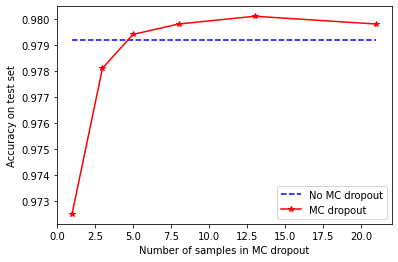

In [7]:
accuracy_mc_dropout = {i: sk_metrics.accuracy_score(labels_gt, labels_mc_dropout[i]) for i in labels_mc_dropout.keys()}
accuracy_normal = sk_metrics.accuracy_score(labels_gt, labels_normal)

plt.plot(list(accuracy_mc_dropout.keys()), [accuracy_normal] * len(accuracy_mc_dropout.keys()), 'b--',
        label='No MC dropout')
plt.plot(list(accuracy_mc_dropout.keys()), list(accuracy_mc_dropout.values()), 'r*-',
        label='MC dropout')
plt.xlabel('Number of samples in MC dropout')
plt.ylabel('Accuracy on test set')
plt.legend()
plt.show()

Depending on the seed for MC dropout, the accuracy gets better than the one without MC dropout when sampling 3 or 5 times. Note that the threshold depends on the dropout ratio that is used during model creation.

## Analyze results

Next, cases are analyzed when MC dropout improves or worsens the prediction. N = 8 samples are used so that there are definitely a few such cases.

In [8]:
num_samples_eval = 8

mask_correct_mc_dropout = (labels_gt == labels_mc_dropout[num_samples_eval])
mask_correct_normal = (labels_gt == labels_normal)
mask_results_different = (labels_normal != labels_mc_dropout[num_samples_eval])

# Indices of samples where either the approach with or without MC dropout is correct and the other is wrong:
indices_diff_mc_correct = np.logical_and(mask_results_different, mask_correct_mc_dropout).nonzero()[0]
indices_diff_normal_correct = np.logical_and(mask_results_different, mask_correct_normal).nonzero()[0]

print("Number of samples where both approaches differ and MC dropout is correct: {}".format(len(indices_diff_mc_correct)))
print("Number of samples where both approaches differ and normal is correct: {}".format(len(indices_diff_normal_correct)))

Number of samples where both approaches differ and MC dropout is correct: 86
Number of samples where both approaches differ and normal is correct: 80


The set of samples where both approaches yield different results is bigger than expected. The small performance gain of the approach using MC dropout is thus not from a few samples where it performs better. 

Next, scores are plotted for ten randomly chosen samples for which the approach with and without MC dropout are correct and the other approach yields wrong results. 

In [9]:
def plot_scores_for_idx(idx, label_gt, label_mc_dropout, label_normal, scores_mc_dropout, scores_normal):
    part1 = "Correct label: {}".format(label_gt)
    part2 = "Predicted label with / without MC dropout: {} / {}".format(label_mc_dropout, label_normal)
    plot_title = part1 + '\n' + part2
    plt.title(plot_title)
    plt.plot(scores_normal[idx], 'b*-', label='No MC dropout')
    
    scores = []
    for i in range(num_samples_eval):
        scores_this_sample = scores_mc_dropout[i][idx]
        scores.append(scores_this_sample)
        plt.plot(scores_this_sample, 'y--')
    
    scores = np.array(scores)
    plt.plot(np.mean(scores, axis=0), 'r*-', label='MC dropout')
    
    plt.xlabel("Label")
    plt.ylabel("Scores")
    plt.legend()
        
    plt.show()
    

indices_mc_correct = sorted(np.random.choice(indices_diff_mc_correct, size=10, replace=False))
indices_normal_correct = sorted(np.random.choice(indices_diff_normal_correct, size=10, replace=False))

The next plots show the scores for some samples from the test set where the approach using MC dropout yields the correct result while the approach without does not. The blue line is the score without MC dropout, the yellow lines are scores for MC dropout samples and the red line is the concensus score from MC dropout obtained by averaging the scores from all dropout samples.

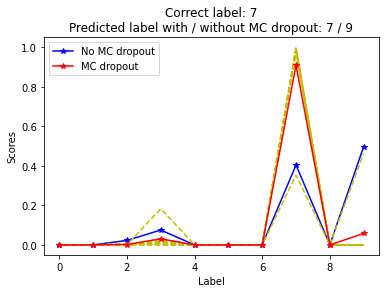

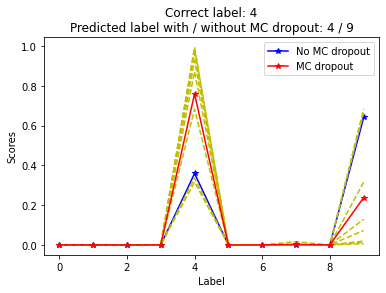

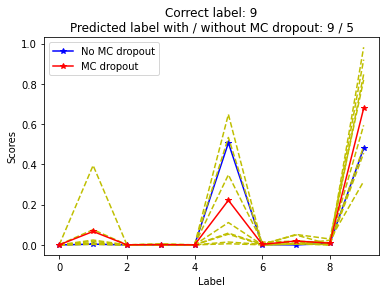

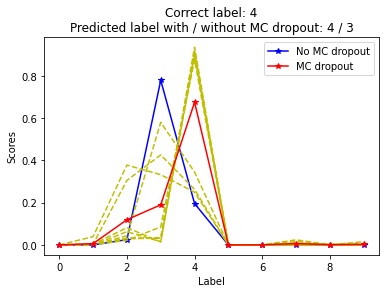

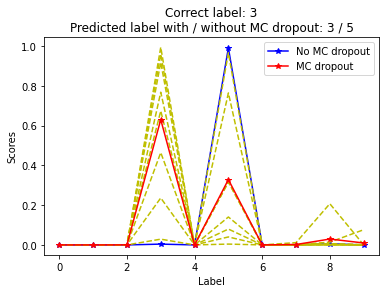

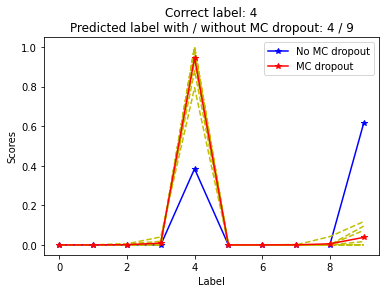

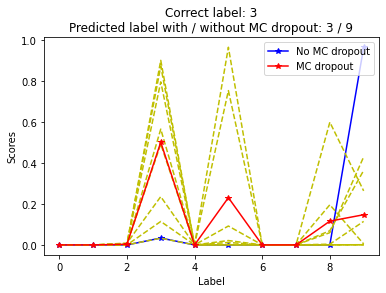

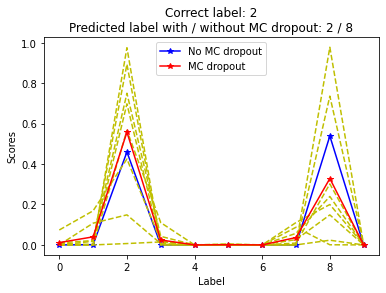

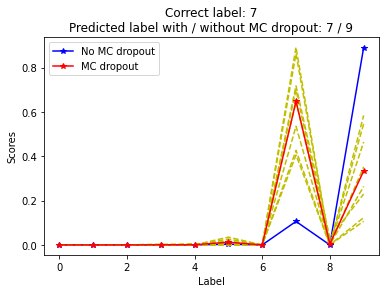

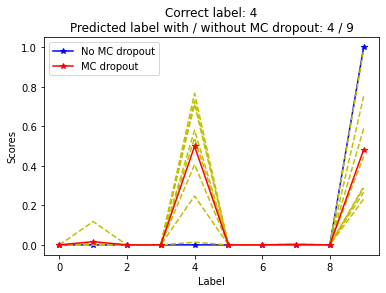

In [10]:
for idx in indices_mc_correct:
    plot_scores_for_idx(idx, labels_gt[idx], labels_mc_dropout[num_samples_eval][idx], labels_normal[idx],
                       scores_mc_dropout[num_samples_eval], scores_normal)


The next plots are similar to the previous ones, but show results where the approach using MC dropout yields the wrong results, while the approach without yields the correct results. The color scheme is the same as in the previous plots. Note that the scores obtained by using MC dropout contain a sizable signal for the correct label, even if the consensus label is wrong.

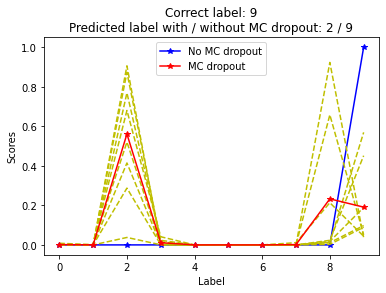

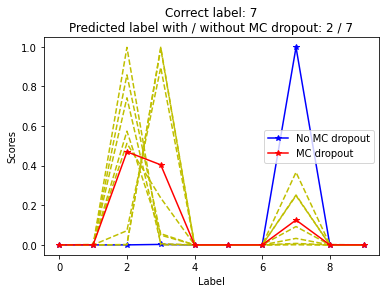

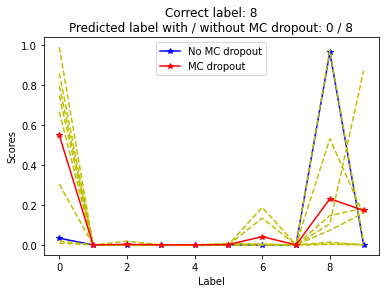

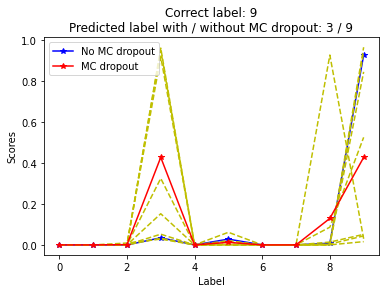

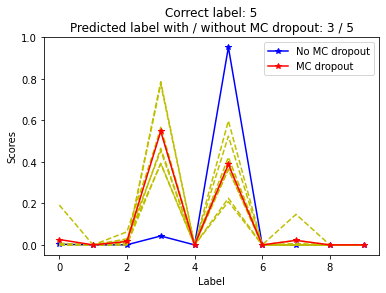

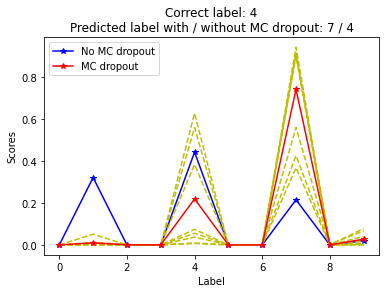

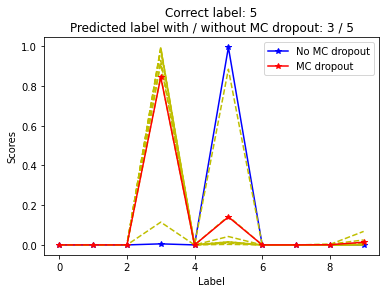

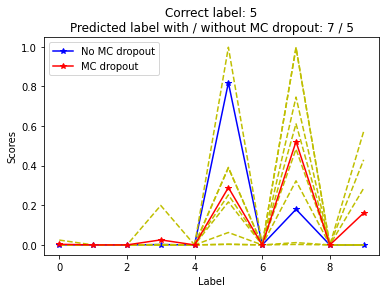

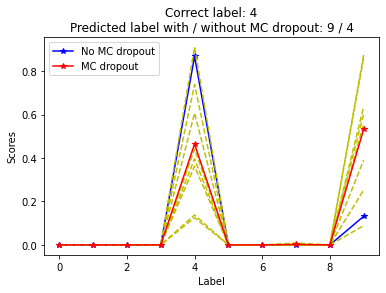

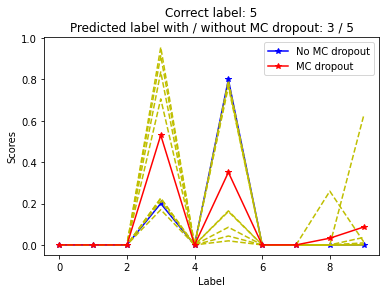

In [11]:
for idx in indices_normal_correct:
    plot_scores_for_idx(idx, labels_gt[idx], labels_mc_dropout[num_samples_eval][idx], labels_normal[idx],
                       scores_mc_dropout[num_samples_eval], scores_normal)

It is nice to see that using MC dropout improves the accuracy of the model. Needless to say, the same improvement could have been obtained by improving the model. However, the focus of this notebook is on experimenting with MC dropout...